In [1]:
pwd

'/mnt/md0/isshamie/Projects/Mito_Trace/workflow/notebooks/clone_af_dendrograms'

In [2]:

# INDIR = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/"
# OUTDIR = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/barcodes/btwnClones_dendro_dt_0.6/"
# DONOR = 0
# dendroThresh=0.6

#clones_meta = '/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/results/clones_summary/feb23_2022/clones_summary.csv'
#clones_indir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/"
#clone_sizes_in_f = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/gff_A2_black/annotation_clones/clone_counts/minCellConds_1/clone_sizes.csv"
# INDIR = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2//data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/"
# OUTDIR = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/barcodes/btwnClones_dendro_dt_dynamic"
# DONOR = 0

INDIR = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_prefilterMerge_impute/knn/kparam_30"
OUTDIR = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_prefilterMerge_impute/knn/kparam_30/barcodes/btwnClones_dendro_dt_dynamic"
DONOR = 0

dendroThresh = "dynamic"

# INDIR = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30"
# OUTDIR = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/barcodes/btwnClones_dendro_dt_0.6"
# DONOR = 1
#dendroThresh = "dynamic" #0.6

verbose=False

mt_ref="/data/Mito_Trace/data/processed/genomes/mtMasked/GRCh38_MT_blacklist_A2_2020/chrM.fasta"

In [3]:
import src.utils.variant_utils as vu
import src.utils.dendro_clust as dc

import mplh.cluster_help as ch
import mplh.fig_utils as fu

from os.path import join, exists, dirname
from glob import glob
import pickle
import os
import vireoSNP
import numpy as np
from scipy import sparse
from scipy.io import mmread
import matplotlib.pyplot as plt
from scipy.stats import hypergeom
print(vireoSNP.__version__)
import pandas as pd
import seaborn as sns
from vireoSNP import Vireo
np.set_printoptions(formatter={'float': lambda x: format(x, '.5f')})
import scipy
from itertools import combinations
#from src.utils import utils  as ut

fig_utils from mplh
0.5.6


In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
out_f = join(OUTDIR, f"donor{DONOR}")

### Load cells_meta 
### Create clones_meta - get number of cells in a clone and donor

In [6]:
cells_meta = pd.read_csv(join(INDIR, "cells_meta.tsv"), sep="\t")
cells_meta["lineage"] = cells_meta.apply(lambda x: f'{x["donor"]}_{x["lineage"]}', axis=1)
cells_meta

,ID,lineage,donor,condition
0,AAACTGCAGACTTCCA-1_Input,0_0,0,Input
1,AAACTGCTCCAACGCG-1_Input,0_0,0,Input
2,AAAGGATCAGATAAGT-1_Input,0_0,0,Input
3,AAAGGATTCCTGACCT-1_Input,0_0,0,Input
4,AAAGGGCTCGTTACAG-1_Input,0_0,0,Input
...,...,...,...,...
6604,TAGGTGTGTACGTAAA-1_Input,1_25,1,Input
6605,TCCCACAGTTCAGAAA-1_Input,1_25,1,Input
6606,TCTCAGCCAGCAATGG-1_Input,1_25,1,Input
6607,TGGGTGCAGCGCCTAC-1_Input,1_25,1,Input


In [7]:
clones_meta_df = pd.DataFrame(cells_meta.groupby("lineage").size(), columns=["size"]) #, index=["size"])
clones_meta_df["donor"] = [x.split("_")[0] for x in clones_meta_df.index]
clones_meta_df["donor"] = clones_meta_df["donor"].astype(int)
clones_meta_df

,size,donor
lineage,,
0_0,447,0
0_1,279,0
0_10,106,0
0_11,105,0
0_12,104,0
...,...,...
1_5,165,1
1_6,159,1
1_7,142,1


In [8]:
curr_clones = clones_meta_df[clones_meta_df["donor"]==DONOR]
# cells_meta = pd.read_csv(join(INDIR, "cells_meta.tsv"), sep='\t')#.sort_values(["donor", "lineage"])
curr_labels = cells_meta[cells_meta["donor"]==DONOR]

In [9]:
# curr_clones = clones_meta_df[clones_meta_df["donor"]==DONOR].set_index("lineage")
# curr_clones

## Load AF and DP

In [10]:
af_indir = join(INDIR, "sc_af", f"donor{DONOR}")
AF_df = pd.read_csv(join(af_indir, "af.tsv"), index_col=0, sep="\t")
DP_df = pd.read_csv(join(af_indir, "dp.tsv"), index_col=0, sep="\t")


### Functions to get mean and median

In [11]:
def calc_mean(cells, af):
    #print(cells.head())
    return af.loc[:,cells["ID"].values].mean(axis=1)

def calc_median(cells, af):
    #print(cells.head())
    return af.loc[:,cells["ID"].values].median(axis=1)

### Calculate clone-barcode mean

In [12]:
mean_af = curr_labels.groupby(["lineage"]).apply(calc_mean, af=AF_df)
anno = mean_af.reset_index()[["lineage"]]

# Remove clones that have all 0
# print('mean_af shape', mean_af.shape)
# mean_af = mean_af.loc[~((mean_af==0).all(axis=1))]
# curr_clones = curr_clones.loc[mean_af.index]
# print('mean_af shape after rm 0', mean_af.shape)

mean_dp = curr_labels.groupby(["lineage"]).apply(calc_mean, af=np.log2(DP_df+1))
mean_dp = mean_dp.loc[mean_af.index, mean_af.columns]

#mean_dp = mean_dp.reset_index(drop=True)
anno_dp = mean_dp.reset_index()[["lineage"]]
na_cells = curr_labels.loc[curr_labels["lineage"].isnull()]
na_mean_af = na_cells.groupby("condition").apply(calc_mean, af=AF_df)

if not (na_mean_af.shape[0] == 0):
    print('na shape', na_mean_af.shape)
    na_anno = pd.concat((anno,pd.DataFrame({"lineage":["None"]*len(na_mean_af.index)})), ignore_index=True)
    na_concat = pd.concat((mean_af.reset_index(drop=True), na_mean_af.reset_index(drop=True)), ignore_index=True)
    na_mean_dp = na_cells.groupby("condition").apply(calc_mean, af=np.log2(DP_df+1))
    na_dp_concat = pd.concat((mean_dp, na_mean_dp.reset_index(drop=True)), ignore_index=True)
else:
    na_anno = anno
    na_concat = mean_af.reset_index(drop=True)
    na_dp_concat = mean_dp
     
mean_af  

Variant,146A,709A,930A,1413A,1888A,1949A,2442A,2514A,2857A,3242A,...,15607G,16519G,2623T,3735T,7361T,7485T,7639T,12283T,16294T,16296T
lineage,,,,,,,,,,,,,,,,,,,,,
0_0,7.961701e-07,0.003577,0.003781,0.000211,0.004577,0.000618,0.000181,0.004234,0.000000,0.005276,...,0.007020,0.000281,0.000091,0.003447,0.003110,0.000193,0.003139,0.002216,0.000995,0.000324
0_1,2.530044e-04,0.000924,0.000450,0.000264,0.000148,0.000472,0.000171,0.000000,0.000146,0.000082,...,0.000643,0.000000,0.000255,0.000172,0.000129,0.000226,0.001165,0.000500,0.000234,0.000181
0_10,2.858776e-04,0.000281,0.000526,0.000071,0.001198,0.002033,0.000000,0.001163,0.000166,0.000074,...,0.000981,0.000230,0.000000,0.001137,0.002125,0.000091,0.000571,0.000818,0.000000,0.000248
0_11,4.981328e-04,0.001591,0.002227,0.000000,0.000220,0.002717,0.000000,0.000858,0.000000,0.000102,...,0.001919,0.000000,0.000000,0.000984,0.001027,0.000000,0.007380,0.013708,0.000235,0.000235
0_12,1.711000e-06,0.002170,0.001744,0.000000,0.003174,0.279984,0.000401,0.001624,0.000604,0.000000,...,0.001648,0.000000,0.000818,0.002539,0.002412,0.000000,0.001146,0.002388,0.001872,0.002180
0_13,0.000000e+00,0.003968,0.000508,0.000000,0.001755,0.001019,0.000000,0.001379,0.000000,0.000000,...,0.003953,0.000800,0.000147,0.000538,0.002017,0.000000,0.000921,0.001781,0.000250,0.000253
0_14,2.148228e-04,0.000489,0.001340,0.000000,0.000962,0.001489,0.000000,0.000734,0.000917,0.000638,...,0.002194,0.000177,0.000000,0.000816,0.001745,0.000173,0.002511,0.001789,0.000592,0.000615
0_15,1.853584e-06,0.001190,0.001967,0.000000,0.000580,0.017700,0.000000,0.000872,0.000237,0.010217,...,0.001658,0.000000,0.000193,0.000208,0.001172,0.000193,0.002319,0.001018,0.000210,0.000213
0_16,1.955429e-06,0.002674,0.001730,0.000403,0.003232,0.002667,0.000000,0.000970,0.000147,0.006349,...,0.001899,0.000000,0.002165,0.001715,0.001258,0.000366,0.002400,0.001022,0.000000,0.000000


In [13]:
# Get variant types
variants_df = vu.add_ref_to_variants(variants=mean_af.columns.values,
                                     mt_df=vu.load_mt_ref(mt_ref))

variants_df = vu.type_of_variants(variants_df, to_preproc=False)

# mean_af.to_csv(out_f+".initInds.mean.csv")

# curr_clones[["donor","size", "log2_fold","-log10(fold p_adj)", "shuffle_sig", 
#              "ncells"]+ list(curr_labels["condition"].unique())].to_csv(out_f+".initInds.indsMeta.csv")

### Cluster to get dendro results

In [14]:
if mean_af.shape[0] == 1 or  mean_af.shape[1] == 1 :
    print('no clustering needed only one var')
else:
    g = sns.clustermap(mean_af, row_cluster=True, col_cluster=True, vmax=0.2, vmin=0)
    inds = g.dendrogram_row.dendrogram["leaves"]
    cols = g.dendrogram_col.dendrogram["leaves"]
    curr_clones = curr_clones.iloc[inds]
    plt.close(g.fig)

### Cluster and calculate proper size

In [16]:
%matplotlib inline
if not (mean_af.shape[0] == 1 or  mean_af.shape[1] == 1 ):
    if dendroThresh == "dynamic":
        clusters, link = dc.run_dynamic_hyper(np.sqrt(np.clip(mean_af, 0, 0.4)))
        #clusters, link = dc.run_dynamic_hyper(np.sqrt(mean_af))
        
        #clusters, link = dc.run_dynamic(mean_af, metric='euclidean', method="average", minClusterSize=1)
        curr_clones["den_clust"] = curr_clones.apply(lambda x: f'C{clusters.loc[x.name, "labels"]}', axis=1)
    else:
        den = dc.dendro_cluster(mean_af, g, d_thresh=dendroThresh)

        if verbose:
            print('icoord and color list')
            print(len(den["icoord"]))
            print(len(den["color_list"]))
            print('leaves leaves color and mean_af shape')
            print(len(den["leaves"]))
            print(len(den["leaves_color_list"]))
            print(mean_af.shape)
        # cluster_classes = dc.get_cluster_classes(den)
        curr_clones = dc.add_cluster_labels(den,curr_clones)
        curr_clones

    size_pvals = dc.cluster_stats(curr_clones, out_f= out_f )

    curr_clones["donor"]= [x.split("_")[0] for x in curr_clones.index]
    curr_clones = curr_clones.loc[mean_af.index]

    # with open(out_f + ".dendrogram_pvals.txt", "w") as f:
    #     #for l in size_pvals:
    #     f.write("\n".join(size_pvals))
else:
    with open(out_f+".dendrogram_pvals.txt", "w") as f:
        f.write("no cells")
    

distances
[0.28796 0.04052 0.26622 0.13745 0.24077 0.03972 0.25857 0.25770 0.38877
 0.30426 0.27264 0.01895 0.34272 0.27006 0.04824 0.11099 0.04356 0.27534
 0.26849 0.26664 0.05359 0.29641 0.03822 0.05190 0.30329 0.30527 0.19958
 0.39220 0.47022 0.03570 0.24470 0.25921 0.04864 0.23946 0.24816 0.27643
 0.07313 0.35389 0.10577 0.28413 0.07949 0.09554 0.27401 0.17000 0.05955
 0.27423 0.29295 0.13524 0.29855 0.35280 0.28085 0.09043 0.06631 0.07208
 0.29536 0.07319 0.27174 0.29847 0.21646 0.10347 0.39939 0.29283 0.29339
 0.27204 0.07900 0.08412 0.15658 0.09001 0.05482 0.27303 0.13169 0.28823
 0.03986 0.27340 0.28303 0.39010 0.31705 0.28177 0.02591 0.43221 0.29348
 0.05441 0.13108 0.04256 0.30249 0.26717 0.29333 0.05482 0.29977 0.02416
 0.05411 0.37867 0.33019 0.19515 0.44340 0.49294 0.02888 0.27131 0.29169
 0.07069 0.27771 0.27516 0.33798 0.11234 0.28254 0.09860 0.10480 0.24396
 0.18169 0.07522 0.27633 0.27708 0.13501 0.29389 0.33228 0.27955 0.11988
 0.10584 0.08742 0.29521 0.09978 0.29644 

## Group clones using dendrogram and run stats on size differences in the groups

## Plot with dendro clusters

In [17]:
conditions = cells_meta["condition"].unique()

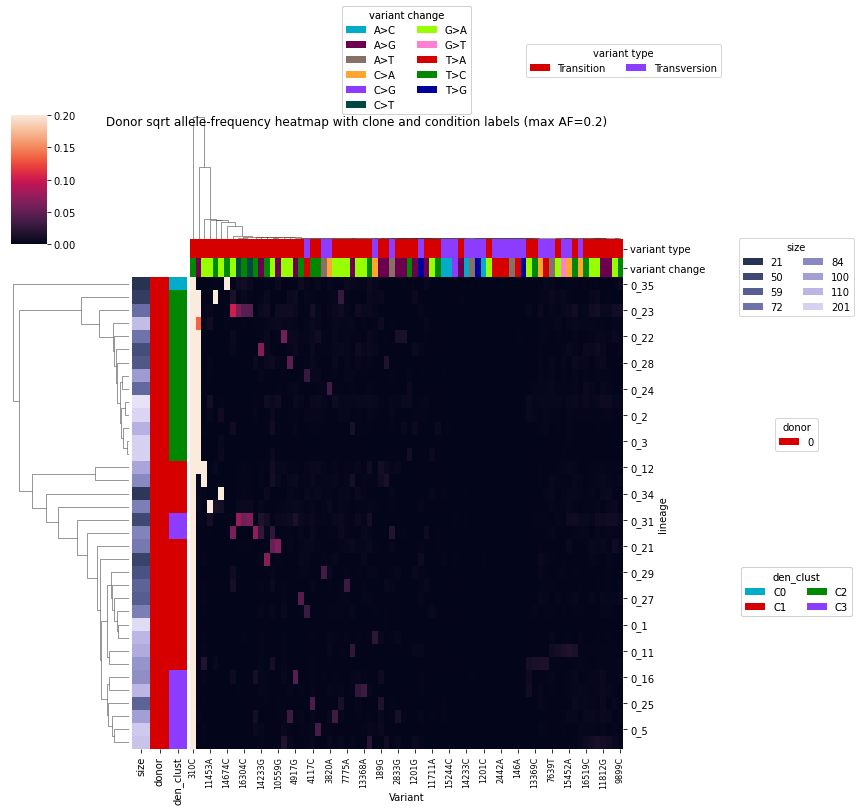

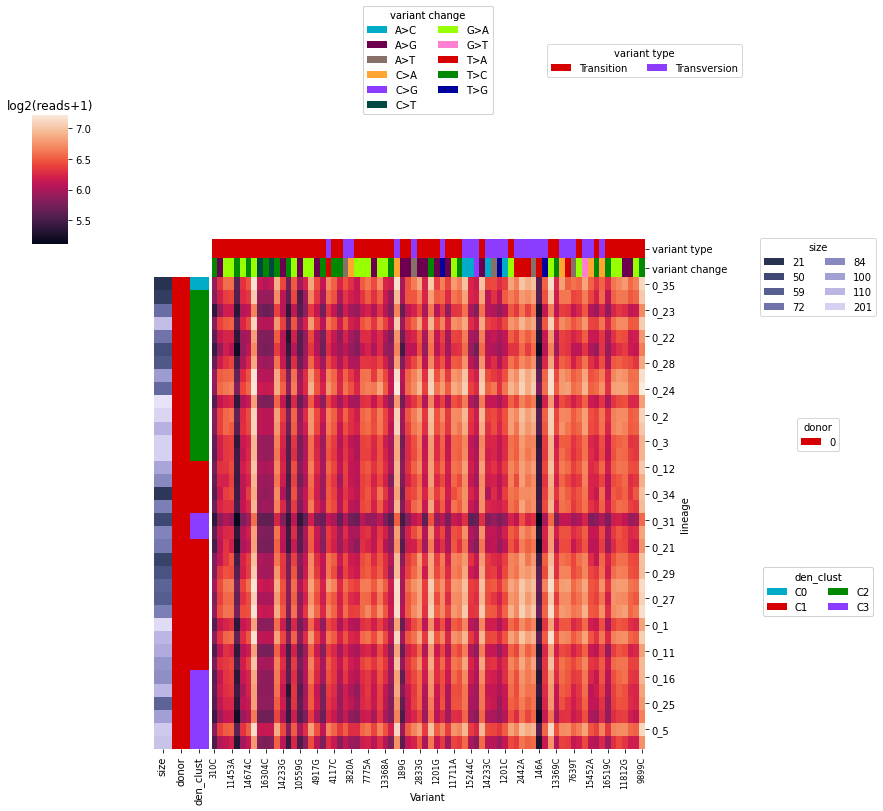

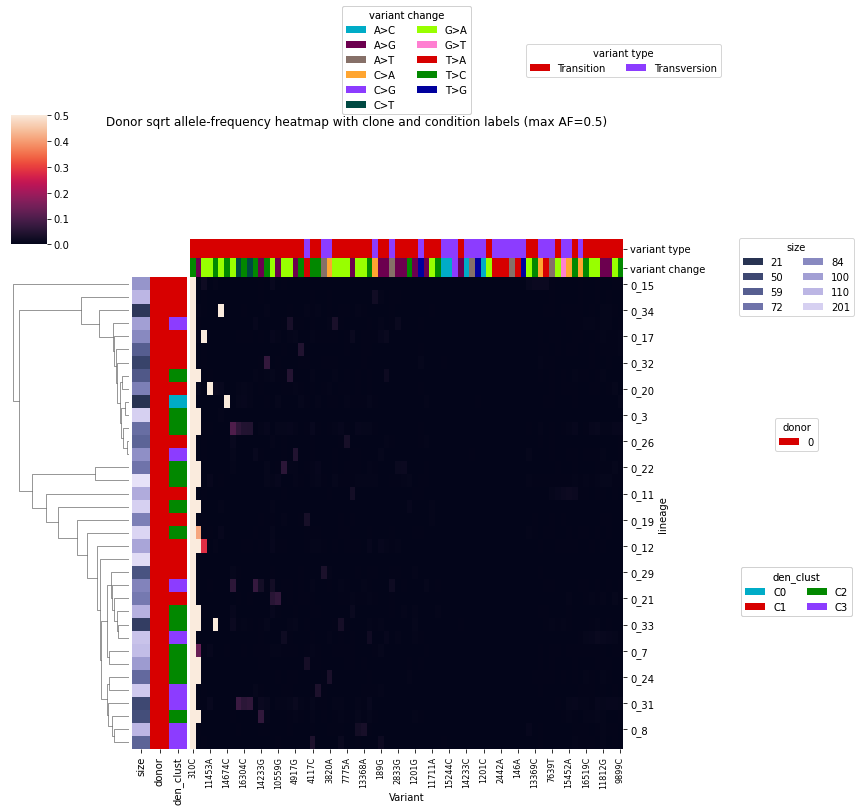

In [18]:
if not (mean_af.shape[0] == 1 or  mean_af.shape[1] == 1 ):
    g = ch.plot_cluster(mean_af,row_meta=curr_clones, to_row_clust=True, to_col_clust=True,
                        col_meta=variants_df[["variant type", "variant change"]], col_clr_schemes="categorical",
                        row_clr_schemes={"size":"sequential","donor":"categorical","den_clust":"categorical"}, 
                        vmax=0.2, vmin=0, 
                        row_linkage=link)
    plt.suptitle("Donor sqrt allele-frequency heatmap with clone and condition labels (max AF=0.2)")
    #fu.helper_save(out_f+"withEnrichmentFoldChange.NoCondition.clust.max2.AF.png",to_pdf=False)
    fu.helper_save(out_f+".dendro.NoCondition.max2.AF.png",to_pdf=False, to_svg=True)

    inds = g.dendrogram_row.dendrogram["leaves"]
    cols = g.dendrogram_col.dendrogram["leaves"]

    
    g1d = ch.plot_cluster(mean_dp.iloc[inds, cols], row_meta=curr_clones, to_row_clust=False, to_col_clust=False,
                          row_clr_schemes={"size":"sequential","donor":"categorical","den_clust":"categorical"}, 
                          col_meta=variants_df[["variant type", "variant change"]], col_clr_schemes="categorical",
                         )
    g1d.ax_cbar.set_title("log2(reads+1)")
    fu.helper_save(out_f+".dendro.NoCondition.DP.png",to_pdf=False, to_svg=True)#, f=g1d.figure)


    mean_af = mean_af.iloc[inds,cols]
    curr_clones = curr_clones.loc[mean_af.index]

    ch.plot_cluster(mean_af,row_meta=curr_clones, row_linkage=link, to_col_clust=False,
                    col_meta=variants_df[["variant type", "variant change"]], col_clr_schemes="categorical",
                    row_clr_schemes={"size":"sequential","donor":"categorical","den_clust":"categorical"}, 
                    vmax=0.5, vmin=0)
    plt.suptitle("Donor sqrt allele-frequency heatmap with clone and condition labels (max AF=0.5)")
    #fu.helper_save(out_f+"withEnrichmentFoldChange.NoCondition.clust.max5.AF.png",to_pdf=False)
    fu.helper_save(out_f+".dendro.NoCondition.max5.AF.png",to_pdf=False, to_svg=True)

else:
    f = plt.figure()
    plt.title("no cells")
    f.savefig(out_f+".dendro.NoCondition.max2.AF.png")


### Save mean_af and curr_clonnes

In [19]:

mean_af.to_csv(out_f+".mean.csv")
curr_clones.to_csv(out_f+".clones_dendro.csv")

## Remove the 0s

In [35]:
out_f_rmLow = out_f + ".rmLowVars"

mean_rmLow_af = mean_af.copy().loc[:,~(mean_af<0.01).all(axis=0)]
mean_rmLow_dp = mean_dp.loc[mean_rmLow_af.index, mean_rmLow_af.columns]


%matplotlib inline
if not (mean_rmLow_af.shape[0] == 1 or  mean_rmLow_af.shape[1] == 1 ):
    if dendroThresh == "dynamic":
        clusters, link = dc.run_dynamic_hyper(np.clip(mean_rmLow_af, 0, 0.4))
        #clusters, link = dc.run_dynamic_hyper(np.sqrt(mean_rmLow_af))
        
        #clusters, link = dc.run_dynamic(mean_rmLow_af, metric='euclidean', method="average", minClusterSize=1)
        curr_clones["den_clust"] = curr_clones.apply(lambda x: f'C{clusters.loc[x.name, "labels"]}', axis=1)
    else:
        den = dc.dendro_cluster(mean_rmLow_af, g, d_thresh=dendroThresh)

        if verbose:
            print('icoord and color list')
            print(len(den["icoord"]))
            print(len(den["color_list"]))
            print('leaves leaves color and mean_rmLow_af shape')
            print(len(den["leaves"]))
            print(len(den["leaves_color_list"]))
            print(mean_rmLow_af.shape)
        # cluster_classes = dc.get_cluster_classes(den)
        curr_clones = dc.add_cluster_labels(den,curr_clones)
        curr_clones

    size_pvals = dc.cluster_stats(curr_clones, out_f= out_f )

    curr_clones["donor"]= [x.split("_")[0] for x in curr_clones.index]
    curr_clones = curr_clones.loc[mean_rmLow_af.index]

    # with open(out_f + ".dendrogram_pvals.txt", "w") as f:
    #     #for l in size_pvals:
    #     f.write("\n".join(size_pvals))
else:
    with open(out_f+".dendrogram_pvals.txt", "w") as f:
        f.write("no cells")
    
curr_clones.loc[mean_rmLow_af.index]
variants_df.loc[mean_rmLow_af.columns]

curr_clones = curr_clones.drop("donor", axis=1)



distances
[0.59030 0.51069 0.32651 0.50268 0.50172 0.50145 0.50048 0.50011 0.49979
 0.49865 0.50023 0.50018 0.49999 0.55108 0.49961 0.49875 0.49994 0.31658
 0.31418 0.30607 0.30257 0.29593 0.29464 0.29605 0.29491 0.29277 0.29366
 0.29549 0.29497 0.29805 0.29512 0.29745 0.29767 0.29441 0.29305 0.20194
 0.26937 0.18871 0.18916 0.18703 0.18481 0.18473 0.18423 0.18323 0.18439
 0.18430 0.18443 0.26460 0.58696 0.58714 0.57221 0.44068 0.43541 0.43354
 0.42999 0.42502 0.42132 0.42422 0.42312 0.42277 0.42113 0.42395 0.41669
 0.42344 0.42260 0.42372 0.42251 0.42361 0.42097 0.12826 0.03040 0.03237
 0.03043 0.02913 0.02976 0.02753 0.02771 0.02633 0.02851 0.02849 0.12671
 0.50545 0.50712 0.49962 0.29271 0.30439 0.32237 0.32029 0.31165 0.30749
 0.31488 0.31343 0.31251 0.31148 0.31295 0.31132 0.31164 0.30946 0.31308
 0.31100 0.31247 0.31120 0.10916 0.11033 0.10750 0.10572 0.10638 0.10452
 0.10480 0.10505 0.10509 0.10506 0.19349 0.32125 0.32648 0.31150 0.08772
 0.07872 0.06927 0.06502 0.05644 0.05449 

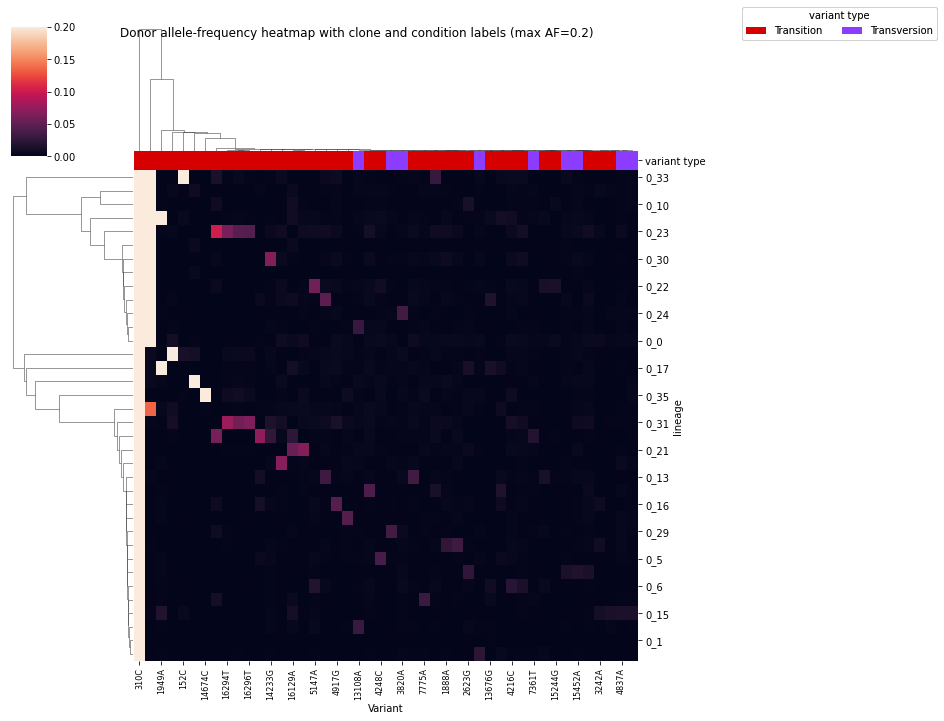

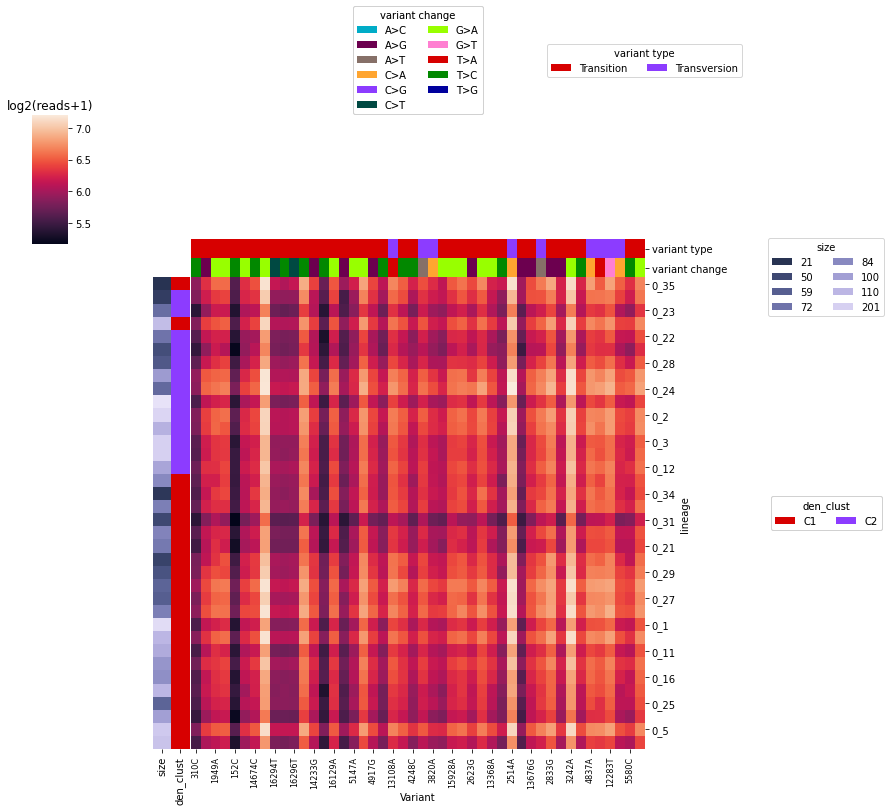

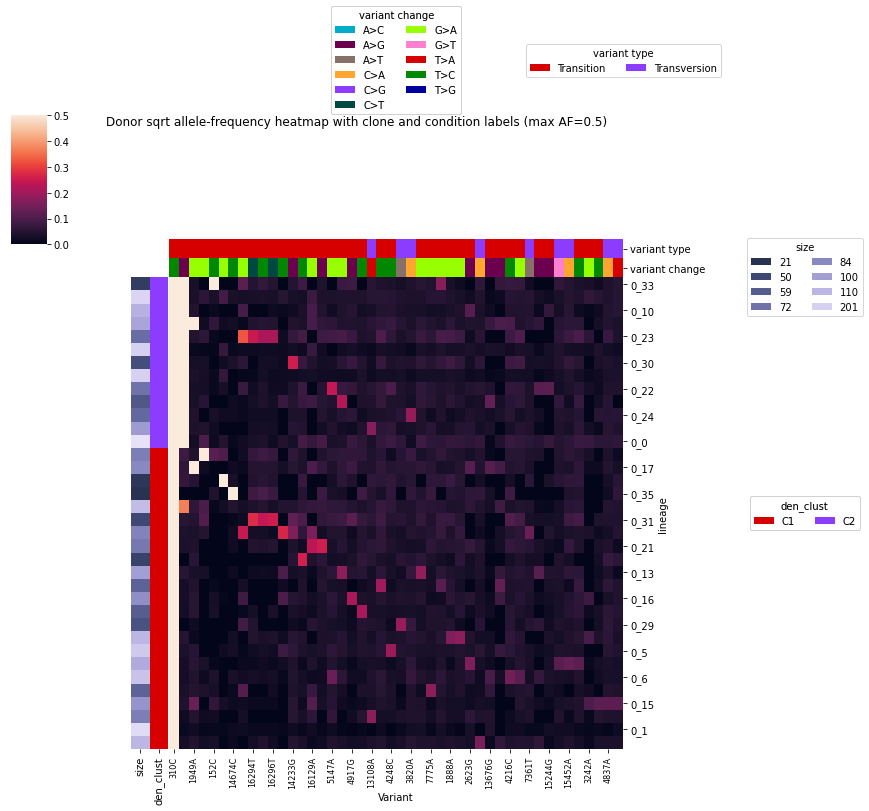

In [38]:

if not (mean_rmLow_af.shape[0] == 1 or  mean_rmLow_af.shape[1] == 1 ):
    g = ch.plot_cluster(mean_rmLow_af,
                        to_row_clust=True, to_col_clust=True,
                        col_meta=variants_df.loc[mean_rmLow_af.columns,["variant type"]], 
                        col_clr_schemes="categorical",
                        vmax=0.2, vmin=0, 
                        )
    plt.suptitle("Donor allele-frequency heatmap with clone and condition labels (max AF=0.2)")
    #fu.helper_save(out_f_rmLow+"withEnrichmentFoldChange.NoCondition.clust.max2.AF.png",to_pdf=False)
    fu.helper_save(out_f_rmLow+".dendro.NoCondition.max2.AF.png",to_pdf=True)

    inds = g.dendrogram_row.dendrogram["leaves"]
    cols = g.dendrogram_col.dendrogram["leaves"]

    g1d = ch.plot_cluster(mean_rmLow_dp.iloc[inds, cols], row_meta=curr_clones, to_row_clust=False, to_col_clust=False,
                          row_clr_schemes={"size":"sequential","donor":"categorical","den_clust":"categorical"}, 
                          col_meta=variants_df[["variant type", "variant change"]], col_clr_schemes="categorical",
                         )
    g1d.ax_cbar.set_title("log2(reads+1)")
    fu.helper_save(out_f_rmLow+".dendro.NoCondition.DP.png",to_pdf=True)#, f=g1d.figure)


    mean_rmLow_af = mean_rmLow_af.iloc[inds,cols]
    curr_clones = curr_clones.loc[mean_rmLow_af.index]

    ch.plot_cluster(np.sqrt(mean_rmLow_af),row_meta=curr_clones, to_row_clust=False, to_col_clust=False,
                    col_meta=variants_df[["variant type", "variant change"]], col_clr_schemes="categorical",
                    row_clr_schemes={"size":"sequential","donor":"categorical","den_clust":"categorical"}, 
                    vmax=0.5, vmin=0)
    plt.suptitle("Donor sqrt allele-frequency heatmap with clone and condition labels (max AF=0.5)")
    #fu.helper_save(out_f_rmLow+"withEnrichmentFoldChange.NoCondition.clust.max5.AF.png",to_pdf=False)
    fu.helper_save(out_f_rmLow+".dendro.NoCondition.max5.AF.png",to_pdf=True)

else:
    f = plt.figure()
    plt.title("no cells")
    f.savefig(out_f_rmLow+".dendro.NoCondition.max2.AF.png")





In [37]:
out_f_rmLow

'/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_prefilterMerge_impute/knn/kparam_30/barcodes/btwnClones_dendro_dt_dynamic/donor0.rmLowVars'